In [7]:
from __future__ import print_function
import sys
import json
import math
from utils import *

import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import time


seed=7
np.random.seed(seed)  # for reproducibility

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Conv1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from hyperbolic_nonlinearities import *
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
start_time = time.time()
sns.despine()

batch_size = 128
nb_epoch = 420
patience = 50
look_back = 7
EMB_SIZE = 5 #numero de colunas.. seria 5 se incluisse volume

def evaluate_model(model, dataset, dadosp, name, n_layers, ep):
    X_train, X_test, Y_train, Y_test = dataset
    X_trainp, X_testp, Y_trainp, Y_testp = dadosp

    csv_logger = CSVLogger('output/%d_layers/%s.csv' % (n_layers, name))
    es = EarlyStopping(monitor='loss', patience=patience)
    #mcp = ModelCheckpoint('output/mnist_adaptative_%dx800/%s.checkpoint' % (n_layers, name), save_weights_only=True)
    #tb = TensorBoard(log_dir='output/mnist_adaptative_%dx800' % n_layers, histogram_freq=1, write_graph=False, write_images=False)

    
    #sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

    #optimizer = sgd
    optimizer = "adam"
    #optimizer = "adadelta"

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
    #X_train = np.expand_dims(X_train, axis=2)
    #X_test = np.expand_dims(X_test, axis=2)

    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=ep, verbose=0, validation_split=0.1, callbacks=[csv_logger,es])

    #trainScore = model.evaluate(X_train, Y_train, verbose=0)
    #print('Train Score: %f MSE (%f RMSE)' % (trainScore, math.sqrt(trainScore)))
    #testScore = model.evaluate(X_test, Y_test, verbose=0)
    #print('Test Score: %f MSE (%f RMSE)' % (testScore, math.sqrt(testScore)))

    # make predictions (scaled)
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    
    
    # invert predictions (back to original)
    params = []
    for xt in X_testp:
        xt = np.array(xt)
        mean_ = xt.mean()
        scale_ = xt.std()
        params.append([mean_, scale_])

    new_predicted = []

    for pred, par in zip(testPredict, params):
        a = pred*par[1]
        a += par[0]
        new_predicted.append(a)


    params2 = []
    for xt in X_trainp:
        xt = np.array(xt)
        mean_ = xt.mean()
        scale_ = xt.std()
        params2.append([mean_, scale_])
        
    new_train_predicted= []

    for pred, par in zip(trainPredict, params2):
        a = pred*par[1]
        a += par[0]
        new_train_predicted.append(a)

    # calculate root mean squared error
    trainScore = mean_squared_error(new_train_predicted, Y_trainp)
    #print('Train Score: %f RMSE' % (trainScore))
    testScore = mean_squared_error(new_predicted, Y_testp)
    #print('Test Score: %f RMSE' % (testScore))
    epochs = len(history.epoch)

    # fig = plt.figure()
    # plt.plot(Y_test[:150], color='black') # BLUE - trained RESULT
    # plt.plot(testPredict[:150], color='blue') # RED - trained PREDICTION
    #plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    #plt.plot(new_predicted[:150], color='red') # ORANGE - restored PREDICTION
    #plt.show()

    return trainScore, testScore, epochs, optimizer



In [8]:
    
    data_original = pd.read_csv('minidolar/wdo.csv', sep = '|',  engine='python', decimal='.',header=0)

    openp = data_original.ix[:, 2].tolist()
    highp = data_original.ix[:, 3].tolist()
    lowp = data_original.ix[:, 4].tolist()
    closep = data_original.ix[:, 5].tolist()
    volumep = data_original.ix[:, 6].tolist()

    # data_chng = data_original.ix[:, 'Adj Close'].pct_change().dropna().tolist()

    WINDOW = 30
    TRAIN_SIZE=WINDOW
    
    STEP = 1
    FORECAST = 1

    X, Y = [], []
    for i in range(0, len(data_original), STEP): 
        try:
            o = openp[i:i+WINDOW+FORECAST]
            h = highp[i:i+WINDOW+FORECAST]
            l = lowp[i:i+WINDOW+FORECAST]
            c = closep[i:i+WINDOW+FORECAST]
            v = volumep[i:i+WINDOW+FORECAST]

            o = (np.array(o) - np.mean(o)) / np.std(o)
            h = (np.array(h) - np.mean(h)) / np.std(h)
            l = (np.array(l) - np.mean(l)) / np.std(l)
            c = (np.array(c) - np.mean(c)) / np.std(c)
            v = (np.array(v) - np.mean(v)) / np.std(v)

            x_i = closep[i:i+WINDOW]
            y_i = closep[i+WINDOW+FORECAST]  

            timeseries = np.array(c)
            x_i = np.column_stack((o[:-1], h[:-1], l[:-1], c[:-1], v[:-1]))
            y_i = timeseries[-1]

        except Exception as e:
            break

        X.append(x_i)
        Y.append(y_i)

    X, Y = np.array(X), np.array(Y)
    X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, 0.5)
    dados = X_train, X_test, Y_train, Y_test
    
    Xp, Yp = [], []
    for i in range(0, len(data_original), STEP): 
        try:
            o = openp[i:i+WINDOW]
            h = highp[i:i+WINDOW]
            l = lowp[i:i+WINDOW]
            c = closep[i:i+WINDOW]
            v = volumep[i:i+WINDOW]

            x_i = closep[i:i+WINDOW]
            y_i = closep[i+WINDOW+FORECAST]  

            timeseries = np.array(closep[i:i+WINDOW+FORECAST])
            x_i = np.column_stack((o, h, l, c, v))
            y_i = timeseries[-1]

        except Exception as e:
            break

        Xp.append(x_i)
        Yp.append(y_i)

    
    Xp, Yp = np.array(Xp), np.array(Yp)
    X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.5)
    dadosp = X_trainp, X_testp, Y_trainp, Y_testp


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [9]:
dados

(array([[[-1.79038244, -2.0703466 , -1.58940678, -1.80463462, -1.09426299],
         [-1.6050674 , -1.27921262, -1.40206225, -1.60730244,  0.73719626],
         [-1.41975236, -1.47699611, -1.87042357, -1.80463462, -0.08955878],
         ..., 
         [ 0.43339809,  0.30305536,  0.37771074,  0.26735328, -0.78560778],
         [ 0.34074057,  0.00638011,  0.19036621,  0.16868719, -0.04389041],
         [ 0.15542552, -0.09251164,  0.28403847,  0.0700211 , -1.5525215 ]],
 
        [[-1.77094819, -1.46296233, -1.53133887, -1.77540771,  0.73793368],
         [-1.5759237 , -1.67638272, -2.01772723, -1.98348952, -0.07535749],
         [-1.86846044, -2.20993369, -1.92044956, -1.87944862, -0.67177101],
         ..., 
         [ 0.27680895, -0.07572981,  0.12238159,  0.09732859, -0.03043283],
         [ 0.08178446, -0.18244001,  0.21965926, -0.00671232, -1.51449557],
         [ 0.08178446,  0.35111096, -0.16945143,  0.40945131,  1.58065824]],
 
        [[-1.73728711, -1.79942464, -2.16207864, -2.

In [10]:
            
            name='relu'
            model = Sequential()

            #model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
            #model.add(Activation(name))

            model.add(Conv1D(input_shape = (TRAIN_SIZE, EMB_SIZE),filters=5,kernel_size=2,activation=name,padding='same',strides=1))
            #model.add(MaxPooling1D(pool_size=2))
            
            
            #model.add(Dropout(0.25))
            model.add(Flatten())

            #model.add(Dense(5))
            #model.add(Dropout(0.25))
            #model.add(Activation(name))
            
            model.add(Dense(1))
            model.add(Activation('linear'))
            #model.summary()

            trainScore, testScore, epochs, optimizer = evaluate_model(model, dados, dadosp, name, 0,nb_epoch)

In [11]:
X_train.shape[2]

5

In [12]:
Y_test.size

5386

In [13]:
    X_train, X_test, Y_train, Y_test = dados
    X_trainp, X_testp, Y_trainp, Y_testp = dadosp

    csv_logger = CSVLogger('output/%d_layers/%s.csv' % (0, name))
    es = EarlyStopping(monitor='loss', patience=patience)
    #mcp = ModelCheckpoint('output/mnist_adaptative_%dx800/%s.checkpoint' % (n_layers, name), save_weights_only=True)
    #tb = TensorBoard(log_dir='output/mnist_adaptative_%dx800' % n_layers, histogram_freq=1, write_graph=False, write_images=False)

    
    #sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

    #optimizer = sgd
    optimizer = "adam"
    #optimizer = "adadelta"

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
    #X_train = np.expand_dims(X_train, axis=2)
    #X_test = np.expand_dims(X_test, axis=2)

    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=0, validation_split=0.1, callbacks=[csv_logger,es])

    #trainScore = model.evaluate(X_train, Y_train, verbose=0)
    #print('Train Score: %f MSE (%f RMSE)' % (trainScore, math.sqrt(trainScore)))
    #testScore = model.evaluate(X_test, Y_test, verbose=0)
    #print('Test Score: %f MSE (%f RMSE)' % (testScore, math.sqrt(testScore)))

    # make predictions (scaled)
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

In [109]:
    # invert predictions (back to original)
    params = []
    for xt in X_testp:
        xt = np.array(xt[:,3]) # close
        mean_ = xt.mean()
        scale_ = xt.std()
        params.append([mean_, scale_])

    new_predicted = []

    for pred, par in zip(testPredict, params):
        a = pred*par[1]
        a += par[0]
        new_predicted.append(a)


    params2 = []
    for xt in X_trainp:
        xt = np.array(xt[:,3]) # close
        mean_ = xt.mean()
        scale_ = xt.std()
        params2.append([mean_, scale_])
        
    new_train_predicted= []

    for pred, par in zip(trainPredict, params2):
        a = pred*par[1]
        a += par[0]
        new_train_predicted.append(a)

    # calculate root mean squared error
    trainScore = mean_squared_error(new_train_predicted, Y_trainp)
    #print('Train Score: %f RMSE' % (trainScore))
    testScore = mean_squared_error(new_predicted, Y_testp)
    #print('Test Score: %f RMSE' % (testScore))
    epochs = len(history.epoch)

In [112]:
testScore

0.22365822216147965

In [113]:
trainScore

0.36276058341577966

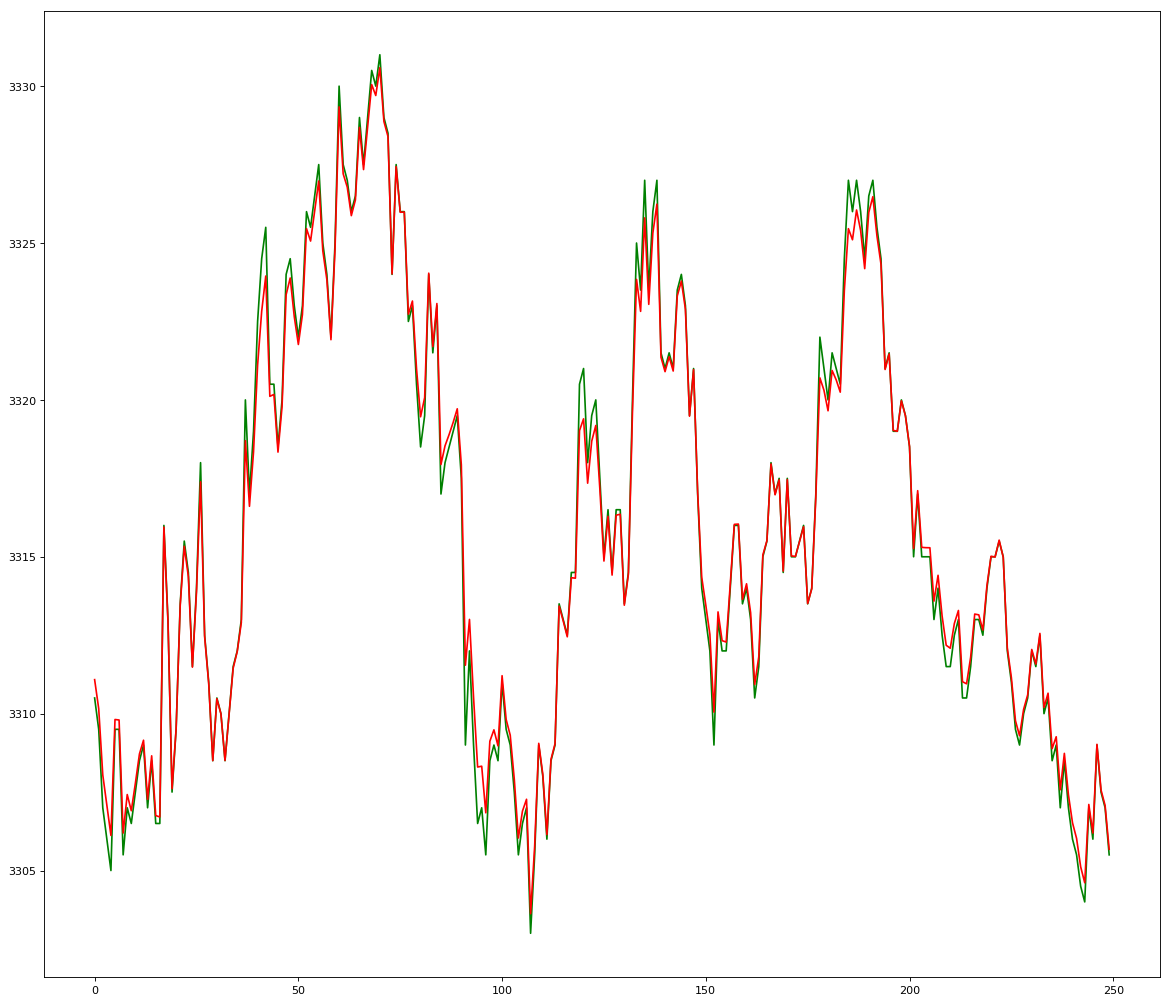

In [129]:
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#plt.plot(Y_test[:50], color='black') # BLUE - trained RESULT
#plt.plot(testPredict[:50], color='blue') # RED - trained PREDICTION
plt.plot(Y_testp[:250], color='green') # GREEN - actual RESULT
plt.plot(new_predicted[:250], color='red') # ORANGE - restored PREDICTION
plt.show()
